In [207]:
from choquet_integral import *
import numpy as np
import cv2
import itertools
import math
import inspect
import matplotlib.pyplot as plt
import csv
import sklearn.metrics as metrics
from scipy.stats import entropy
import random
import xai_indices as xai
import pyemd

In [208]:
from sklearn import datasets
from emd_clustertend import vat, ivat
from sklearn.preprocessing import scale

In [209]:
chi = ChoquetIntegral()

data = np.random.rand(4, 100)
labels = np.amax(data, 0)
data2 = data[::-1,:]
labels2 = np.amin(data2,0)

data = np.concatenate((data,data2),axis=1)
labels = np.concatenate((labels,labels2))

# train the chi via quadratic program 
chi.train_chi(data, labels)

# print out the learned chi variables. (in this case, all 1's) 
chi.fm

Number Inputs :  4 ; Number Samples :  200
     pcost       dcost       gap    pres   dres
 0: -6.0491e+01 -6.6346e+01  7e+01  7e+00  2e-01
 1: -5.8408e+01 -6.6269e+01  1e+01  3e-01  7e-03
 2: -5.9225e+01 -6.1020e+01  2e+00  5e-02  1e-03
 3: -5.9726e+01 -6.0211e+01  5e-01  5e-04  1e-05
 4: -5.9804e+01 -5.9831e+01  3e-02  2e-05  5e-07
 5: -5.9812e+01 -5.9813e+01  5e-04  2e-07  6e-09
 6: -5.9812e+01 -5.9812e+01  5e-06  2e-09  6e-11
Optimal solution found.


{'[1]': 0.35130082368892224,
 '[2]': 0.35608654851355154,
 '[3]': 0.35130055802304383,
 '[4]': 0.16959190146536943,
 '[1 2]': 0.6743477555946286,
 '[1 3]': 0.3513008372828401,
 '[1 4]': 0.3513042973110788,
 '[2 3]': 0.45434129092529696,
 '[2 4]': 0.7814703516190408,
 '[3 4]': 0.35130057647291546,
 '[1 2 3]': 0.6743478123963615,
 '[1 2 4]': 0.9059957915320794,
 '[1 3 4]': 0.3513044150867414,
 '[2 3 4]': 0.7814703936234659,
 '[1 2 3 4]': 1.0}

In [244]:
custom = ChoquetIntegral()
custom.N = 4
customfm = {}
customfm[str(np.asarray([1]))] = .9
customfm[str(np.asarray([2]))] = 0
customfm[str(np.asarray([3]))] = 0
customfm[str(np.asarray([4]))] = 0
customfm[str(np.asarray([1,2]))] = .9
customfm[str(np.asarray([1,3]))] = .9
customfm[str(np.asarray([1,4]))] = .9
customfm[str(np.asarray([2,3]))] = 0
customfm[str(np.asarray([2,4]))] = 0
customfm[str(np.asarray([3,4]))] = 0
customfm[str(np.asarray([1,2,3]))] = .9
customfm[str(np.asarray([1,2,4]))] = .9
customfm[str(np.asarray([1,3,4]))] = .9
customfm[str(np.asarray([2,3,4]))] = 0
customfm[str(np.asarray([1,2,3,4]))] = 1

custom.fm = customfm
custom.type='quad'
print(custom.fm)


{'[1]': 0.9, '[2]': 0, '[3]': 0, '[4]': 0, '[1 2]': 0.9, '[1 3]': 0.9, '[1 4]': 0.9, '[2 3]': 0, '[2 4]': 0, '[3 4]': 0, '[1 2 3]': 0.9, '[1 2 4]': 0.9, '[1 3 4]': 0.9, '[2 3 4]': 0, '[1 2 3 4]': 1}
[1]
[2]
[3]
[4]
[1 2]
[1 3]
[1 4]
[2 3]
[2 4]
[3 4]
[1 2 3]
[1 2 4]
[1 3 4]
[2 3 4]
[1 2 3 4]


In [486]:
def random_node_fm(n):
    n = 4
    ch = ChoquetIntegral()
    ch.type='quad'
    ch.fm = {}
    ch.fm[str(np.arange(1,n+1))] = 1
    ch.fm['[]'] = 0
    ch.N = n
    numkeys = len(ch.get_keys_index())
    keys = list(ch.get_keys_index().keys())
    keys.append('[]')
    s = [0] * (numkeys + 1)
    s[-1] = 1
    s[-2] = 1
    done = False
    while not done:
        randindex = random.randrange(0,numkeys)
        if s[randindex] == 0:
            s[randindex] = 1
            if keys[randindex] != '[]':
                compare_key = [int(s) for s in keys[randindex][1:-1].split() if s.isdigit()]

            else:
                compare_key = []

            maxi = 0
            max_index = 0
            mini = 1
            min_index = 0
            for i,key in enumerate(keys):
                if s[i] == 1 and i != randindex:
                    if key != '[]':
                        stripped = [int(s) for s in key[1:-1].split() if s.isdigit()]
                    else:
                        stripped = []

                    if is_subset(stripped,compare_key) and s[i] == 1 and ch.fm[key] >= maxi:
                        maxi = ch.fm[key]
                        max_index = i
                    if is_subset(compare_key,stripped) and s[i] == 1 and ch.fm[key] <= mini:

                        mini = ch.fm[key]
                        min_index = i


            rb = ch.fm[keys[max_index]]
            ru = ch.fm[keys[min_index]]
            g = random.uniform(rb,ru)
            ch.fm[keys[randindex]] = g

        else:
            pass
        if min(s) == 1:
            done = True
    return ch

In [499]:
# a is subset of b
def is_subset(a,b):
    if len(a) == 0:
        return True
    if len(b) == 0 and len(a) != 0:
        return False
    for val in a:
        if val not in b:
            return False
    else:
        return True
    n=4
    

# compare_key = [int(s) for s in keys[12][1:-1].split() if s.isdigit()]
# # compare_key = list(ch.get_keys_index().keys())[4]
# maxi = 0
# mini = 0
# for i,key in enumerate(keys):
#     stripped = [int(s) for s in key[1:-1].split() if s.isdigit()]
#     if is_subset(stripped,compare_key) and s[i] == 1 and ch.fm[key] > maxi
        
    
# a = [int(s) for s in list(keys.keys())[13][1:-1].split() if s.isdigit()]
# b =[int(s) for s in list(keys.keys())[7][1:-1].split() if s.isdigit()]



{'[1 2 3 4]': 1,
 '[]': 0,
 '[2 3]': 0.19288962185852243,
 '[3]': 0.1026034044192932,
 '[4]': 0.6692548008419716,
 '[1 4]': 0.7429604490717007,
 '[1 3]': 0.520505016696185,
 '[1 3 4]': 0.9094042491077127,
 '[3 4]': 0.8705183130797853,
 '[2 3 4]': 0.8954608823323249,
 '[1 2 4]': 0.7499220995778236,
 '[2]': 0.1771212630473768,
 '[1]': 0.46996768585609994,
 '[1 2 3]': 0.6418664153446233,
 '[1 2]': 0.5319603792820023,
 '[2 4]': 0.7117823502008886}

In [137]:
walk_diffs = custom.generate_walk_diffs()

In [211]:
def sample_with_noise(ch,data,mean,var):
    labels = np.zeros(data.shape[0])
    for i,point in enumerate(data):
        labels[i] = max(min(ch.chi_quad(point) + random.gauss(mean,var),1),0)
    return labels

def gen_datapoints(m,n):
    points = []
    for i in range(n):
        point = []
        for j in range(m):
            point.append(random.random())
        points.append(point)
    return np.asarray(points)


In [212]:
data = gen_datapoints(4,200)
noisy_labels = sample_with_noise(ch,data,0,.1)

noisy_chi = ChoquetIntegral()
noisy_chi.train_chi(data.T,noisy_labels)

xai.walk_visitation(data.T)

Number Inputs :  4 ; Number Samples :  200
     pcost       dcost       gap    pres   dres
 0: -6.6144e+01 -7.4208e+01  7e+01  6e+00  2e-01
 1: -6.5373e+01 -7.2405e+01  1e+01  6e-01  2e-02
 2: -6.5997e+01 -6.7562e+01  2e+00  6e-02  2e-03
 3: -6.6300e+01 -6.6649e+01  4e-01  9e-03  3e-04
 4: -6.6400e+01 -6.6488e+01  9e-02  1e-03  3e-05
 5: -6.6426e+01 -6.6436e+01  9e-03  3e-05  9e-07
 6: -6.6430e+01 -6.6431e+01  1e-03  3e-07  9e-09
 7: -6.6430e+01 -6.6430e+01  4e-05  4e-09  1e-10
Optimal solution found.


({(1, 2, 3, 4): 2,
  (1, 2, 4, 3): 6,
  (1, 3, 2, 4): 6,
  (1, 3, 4, 2): 5,
  (1, 4, 2, 3): 5,
  (1, 4, 3, 2): 12,
  (2, 1, 3, 4): 9,
  (2, 1, 4, 3): 9,
  (2, 3, 1, 4): 7,
  (2, 3, 4, 1): 8,
  (2, 4, 1, 3): 4,
  (2, 4, 3, 1): 21,
  (3, 1, 2, 4): 5,
  (3, 1, 4, 2): 9,
  (3, 2, 1, 4): 6,
  (3, 2, 4, 1): 11,
  (3, 4, 1, 2): 8,
  (3, 4, 2, 1): 10,
  (4, 1, 2, 3): 14,
  (4, 1, 3, 2): 7,
  (4, 2, 1, 3): 5,
  (4, 2, 3, 1): 11,
  (4, 3, 1, 2): 9,
  (4, 3, 2, 1): 11},
 {(1, 2, 3, 4): 0.01,
  (1, 2, 4, 3): 0.03,
  (1, 3, 2, 4): 0.03,
  (1, 3, 4, 2): 0.025,
  (1, 4, 2, 3): 0.025,
  (1, 4, 3, 2): 0.06,
  (2, 1, 3, 4): 0.045,
  (2, 1, 4, 3): 0.045,
  (2, 3, 1, 4): 0.035,
  (2, 3, 4, 1): 0.04,
  (2, 4, 1, 3): 0.02,
  (2, 4, 3, 1): 0.105,
  (3, 1, 2, 4): 0.025,
  (3, 1, 4, 2): 0.045,
  (3, 2, 1, 4): 0.03,
  (3, 2, 4, 1): 0.055,
  (3, 4, 1, 2): 0.04,
  (3, 4, 2, 1): 0.05,
  (4, 1, 2, 3): 0.07,
  (4, 1, 3, 2): 0.035,
  (4, 2, 1, 3): 0.025,
  (4, 2, 3, 1): 0.055,
  (4, 3, 1, 2): 0.045,
  (4, 3, 2, 1): 0

In [29]:
distance_matrix = np.array([[0,1,2,3],
                            [1,0,1,2],
                            [2,1,0,1],
                            [3,2,1,0]],dtype=float)

def gen_unit_distance_matrix(n):
    distance_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            distance_matrix[i][j] = np.abs(i-j)
    return distance_matrix

def emd_pairwise_dissimilarity(X):
    pairwise = np.zeros((X.shape[0],X.shape[0]))
    distance_matrix = gen_unit_distance_matrix(X.shape[1])
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if i == j:
                pairwise[i][j] = 0
            else:
                diff = pyemd.emd(X[i],X[j],distance_matrix)
                pairwise[i][j]=diff
    return pairwise


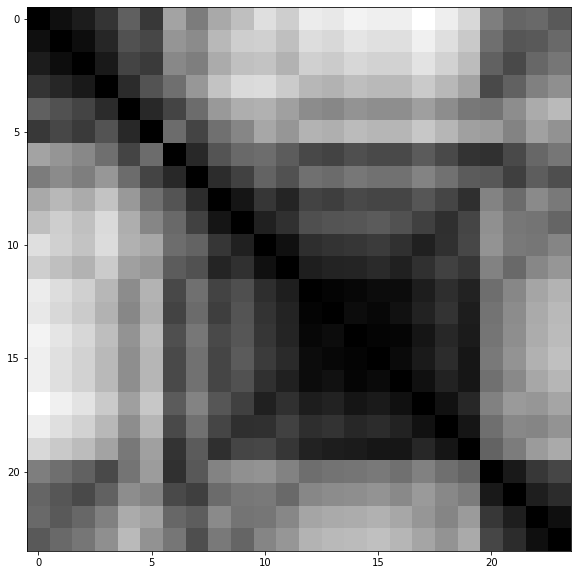

In [503]:
ch = random_node_fm(4)

diffs = ch.generate_walk_diffs()
odm,reorder = vat(diffs,return_odm=True)

In [232]:
a = noisy_chi.generate_walk_diffs()
for row in a:
    r = ["{:.2f}".format(x) for x in row]
    print(r)

['0.84', '0.00', '0.04', '0.12']
['0.84', '0.00', '0.00', '0.16']
['0.84', '0.04', '0.00', '0.12']
['0.84', '0.04', '0.10', '0.02']
['0.84', '0.00', '0.00', '0.16']
['0.84', '0.00', '0.14', '0.02']
['0.06', '0.78', '0.04', '0.12']
['0.06', '0.78', '0.00', '0.16']
['0.06', '0.00', '0.82', '0.12']
['0.06', '0.00', '0.01', '0.92']
['0.06', '0.01', '0.77', '0.16']
['0.06', '0.01', '0.00', '0.92']
['0.01', '0.87', '0.00', '0.12']
['0.01', '0.87', '0.10', '0.02']
['0.01', '0.06', '0.82', '0.12']
['0.01', '0.06', '0.01', '0.92']
['0.01', '0.07', '0.91', '0.02']
['0.01', '0.07', '0.00', '0.92']
['0.08', '0.77', '0.00', '0.16']
['0.08', '0.77', '0.14', '0.02']
['0.08', '0.00', '0.77', '0.16']
['0.08', '0.00', '0.00', '0.92']
['0.08', '0.00', '0.91', '0.02']
['0.08', '0.00', '0.00', '0.92']


In [ ]:
def generate_walk_diffs(chi):
    n = chi.M
    initial = []
    for i in range(n):
        initial.append(i+1)

    index_permutations = itertools.permutations(initial,4)
    walks = np.ndarray((math.factorial(n),n),dtype=int)
    walk_diffs = np.ndarray((math.factorial(n),n),dtype=float)
    for i,val in enumerate(index_permutations):
        walks[i] = np.asarray(val)

        c_build = np.ndarray(n)
        for j in range(len(walks[i])):
            if j == 0:
                c_build[j] = chi.fm[str(walks[i][0:1])]
            else:
                c_build[j] = (chi.fm[str(np.sort(walks[i][0:j+1]))]) - (chi.fm[str(np.sort(walks[i][0:j]))])

        walk_diffs[i] = c_build
    return walk_diffs

In [505]:
def read_crisp(fname):
    part = []
    with open(fname) as csvfile:
        reader = csv.reader(csvfile,delimiter=',')
        for row in reader:
            part.append(row)
    return np.asarray(part,dtype=int)
crisp_part = read_crisp("crisp.csv")

In [206]:
#input: crisp partition matrix, reordering from odm to dm, odm itself
def center_from_crisp(crisp,reordering,odm):
    n = crisp.shape[0]
    row = 0
    num_in_cluster = 0
    cluster_centers = []
    for i in range(n):
        if crisp[row][i] == 1:
            num_in_cluster = num_in_cluster + 1
            
        else:
#             print("new cluster at", i)
            mini = np.inf
            mini_row = row
            for j in range(row,row+num_in_cluster):
                row_sum = np.sum(odm[j][i-num_in_cluster:i])
                if row_sum < mini:
                    mini = row_sum
                    mini_row = j
            cluster_centers.append(reorder[mini_row][0][0])   #the center is row w/ minimum difference, put back in unordered
            row = row+num_in_cluster
            num_in_cluster = 1
            
    mini = np.inf
    mini_row = row
    for j in range(row,row+num_in_cluster):
        row_sum = np.sum(odm[j][i-num_in_cluster+1:i+1])
#         print(row_sum, "sum of row", j)
        if row_sum < mini:
            mini = row_sum
            mini_row = j
    cluster_centers.append(reorder[mini_row][0][0])
    return cluster_centers

In [508]:

print(center_from_crisp(crisp_part,reorder,odm))
ch.generate_walk_diffs()

[9, 16, 21]


array([[0.09943319, 0.36245168, 0.44324466, 0.09487047],
       [0.09943319, 0.36245168, 0.26284665, 0.27526848],
       [0.09943319, 0.06115279, 0.74454354, 0.09487047],
       [0.09943319, 0.06115279, 0.77657875, 0.06283527],
       [0.09943319, 0.16218162, 0.46311671, 0.27526848],
       [0.09943319, 0.16218162, 0.67554992, 0.06283527],
       [0.40612559, 0.05575928, 0.44324466, 0.09487047],
       [0.40612559, 0.05575928, 0.26284665, 0.27526848],
       [0.40612559, 0.24913487, 0.24986907, 0.09487047],
       [0.40612559, 0.24913487, 0.1373568 , 0.20738274],
       [0.40612559, 0.30911925, 0.00948667, 0.27526848],
       [0.40612559, 0.30911925, 0.07737242, 0.20738274],
       [0.07708702, 0.08349897, 0.74454354, 0.09487047],
       [0.07708702, 0.08349897, 0.77657875, 0.06283527],
       [0.07708702, 0.57817344, 0.24986907, 0.09487047],
       [0.07708702, 0.57817344, 0.1373568 , 0.20738274],
       [0.07708702, 0.10606425, 0.75401346, 0.06283527],
       [0.07708702, 0.10606425,

In [504]:
with open('odm.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in odm:
        writer.writerow(row)